In [2]:
%matplotlib inline

import torch
from torch.autograd import Variable
from torch import FloatTensor
import torch.optim as optim

from sklearn.datasets import make_blobs

import numpy as np
from matplotlib import pyplot as plt

from pylab import rcParams

In [3]:
def init_clusters_v1(num_dimensions=2, num_clusters=3, random_state=None): 
    clusters = None
    if random_state is None: 
        clusters = np.random.rand(num_clusters, num_dimensions)
    else:
        clusters = random_state.rand(num_clusters, num_dimensions)
    return Variable(FloatTensor(clusters), requires_grad=True)

In [4]:
def create_dataset(num_samples=100, num_dimensions=2, num_clusters=3, std=1.0, random_state=None): 
    X, y = make_blobs(n_samples=num_samples, 
                      n_features=num_dimensions, 
                      centers=num_clusters, 
                      random_state=random_state, 
                      cluster_std=std)
    return Variable(FloatTensor(X), requires_grad=False), Variable(FloatTensor(y), requires_grad=False)

In [5]:
def calculate_sample_cluster_cost(X, clusters, cost_fn='mean'): 
    norms = []
    
    for c in range(clusters.size()[0]):
        sub = X - clusters[c].resize(1, 2).expand_as(X)
        norm = sub.norm(2, 1)
        norms.append(norm)
    
    norms = torch.cat(norms, 1)
    
    min_norm, clusters_memberships = norms.min(1)
    
    cost = None
    
    if cost_fn is 'mean': 
        cost = min_norm.mean()
    if cost_fn is 'sum': 
        cost = min_norm.sum()
    
    return cost, min_norm, clusters_memberships

In [6]:
def calculate_cluster_cluster_cost(clusters, cost_fn='mean'): 
    clusters_ = clusters

    norms = []

    for c in range(clusters.size()[0]):
        sub = clusters - clusters[c].resize(1, 2).expand_as(clusters)
        #norm = sub.norm(2, 1)
        norm = sub**2
        norms.append(norm)

    cost = None
        
    if cost_fn is 'mean': 
        cost = torch.mean(torch.cat(norms) / 2)
    if cost_fn is 'sum':
        cost = torch.sum(torch.cat(norms) / 2)
        
    return -cost

In [7]:
def kmeans_step(clusters, X, optimizer, cost_fn='mean', alpha=0.0): 
    
    sample_cluster_cost, dist, cluster_assignment = calculate_sample_cluster_cost(X, clusters, cost_fn=cost_fn)
    
    cluster_cluster_cost = calculate_cluster_cluster_cost(clusters, cost_fn=cost_fn)
    
    total_cost = 0
    
    total_cost = sample_cluster_cost 
    
    #total_cost += alpha * cluster_cluster_cost
    
    optimizer.zero_grad()
    
    total_cost.backward()
    
    optimizer.step()
    
    return total_cost, cluster_assignment

In [13]:
def plot(X, clusters, figsize=(10, 10)): 
    rcParams['figure.figsize'] = figsize
    
    X_ = X.data.numpy()
    C_ = clusters.data.numpy()
    
    plt.plot(
        X_[:,0], 
        X_[:,1], 
        'yo'
    )
    plt.plot(
        C_[:, 0], 
        C_[:, 1], 
        'go'
    )
    plt.show()

In [14]:
num_clusters = 3
num_dimensions = 2
cluster_std = 2.0
num_samples = 200

clusters = init_clusters_v1(num_clusters=num_clusters, 
                            random_state=np.random.RandomState(30))

X, y = create_dataset(num_samples=num_samples, 
                      num_clusters=num_clusters, 
                      std=cluster_std, 
                      random_state=np.random.RandomState(10))

optimizer1 = optim.RMSprop([clusters])

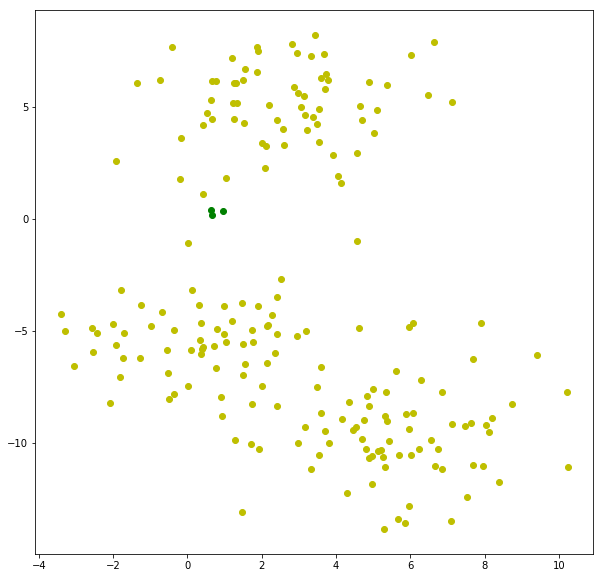

In [82]:
plot(X, clusters)

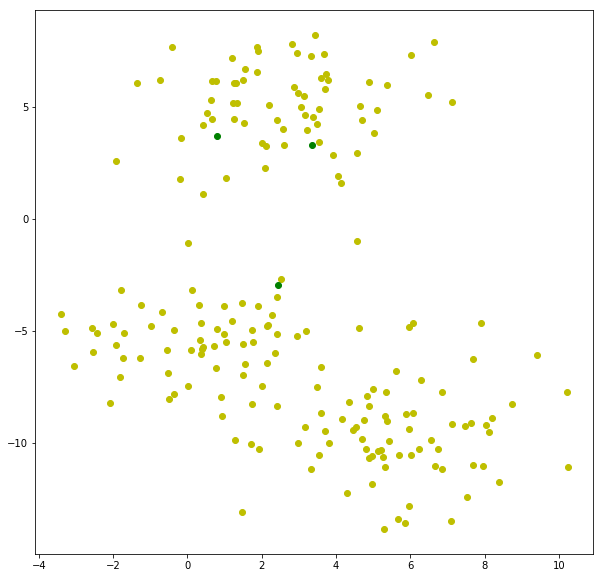

In [83]:
clusters_positions = {}

for i in range(clusters.size()[0]):
    clusters_positions[i] = {
        0: [], 
        1: []
    }

for i in range(200):
    #optimizer1 = optim.RMSprop([clusters])
    optimizer1.zero_grad()
    
    cost, cluster_assignment = kmeans_step(clusters, X, optimizer1)
    
    for i in range(clusters.size()[0]):
        clusters_positions[i][0].append(clusters.data.numpy()[i, 0])
        clusters_positions[i][1].append(clusters.data.numpy()[i, 1])
    
    
plot(X, clusters)

[None, None, None, None]

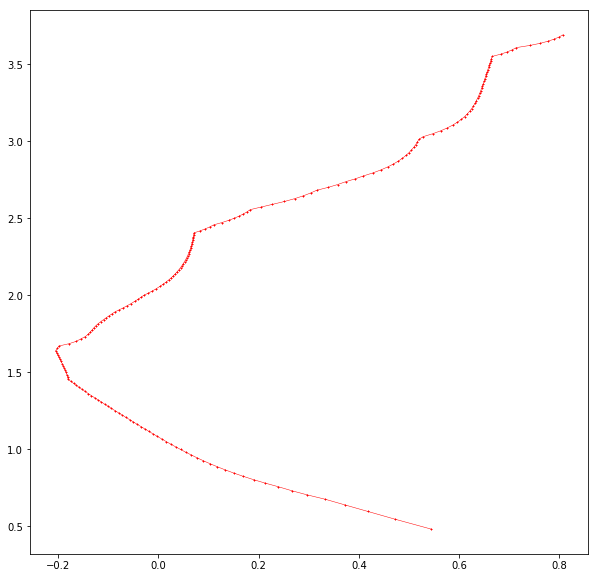

In [119]:
lines = plt.plot(clusters_positions[0][0], clusters_positions[0][1])
plt.setp(lines, color='red', linewidth=0.5, markersize=2, marker='+')

In [21]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [24]:
def step(n_steps=1.0): 
    optimizer1.zero_grad()
    
    for i in range(int(n_steps)):
        kmeans_step(clusters, X, optimizer1)
    
    plot(X, clusters)

In [25]:
interact_manual(step, n_steps=FloatSlider(min=1, max=20, step=1));

A Jupyter Widget